16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 20s 1us/step
Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 615ms/step - accuracy: 0.5533 - loss: 1.2485 - val_accuracy: 0.9281 - val_loss: 0.3471
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 483ms/step - accuracy: 0.9347 - loss: 0.2495 - val_accuracy: 0.9500 - val_loss: 0.2112
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 487ms/step - accuracy: 0.9486 - loss: 0.1677 - val_accuracy: 0.9594 - val_loss: 0.1340
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 499ms/step - accuracy: 0.9727 - loss: 0.1139 - val_accuracy: 0.9531 - val_loss: 0.1318
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 523ms/step - accuracy: 0.9752 - loss: 0.1027 - val_accuracy: 0.9812 - val_loss: 0.0900
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 512ms/step - accuracy: 0.9839 - loss: 0.0733 - val_accuracy: 0.9875 - val_loss: 0.0797
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 502ms/step - accuracy: 0.9872 - loss: 0.0644 - val_accuracy: 0.9781 - val_loss: 0.0789
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 534

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.9594 - loss: 0.1368
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 371ms/step


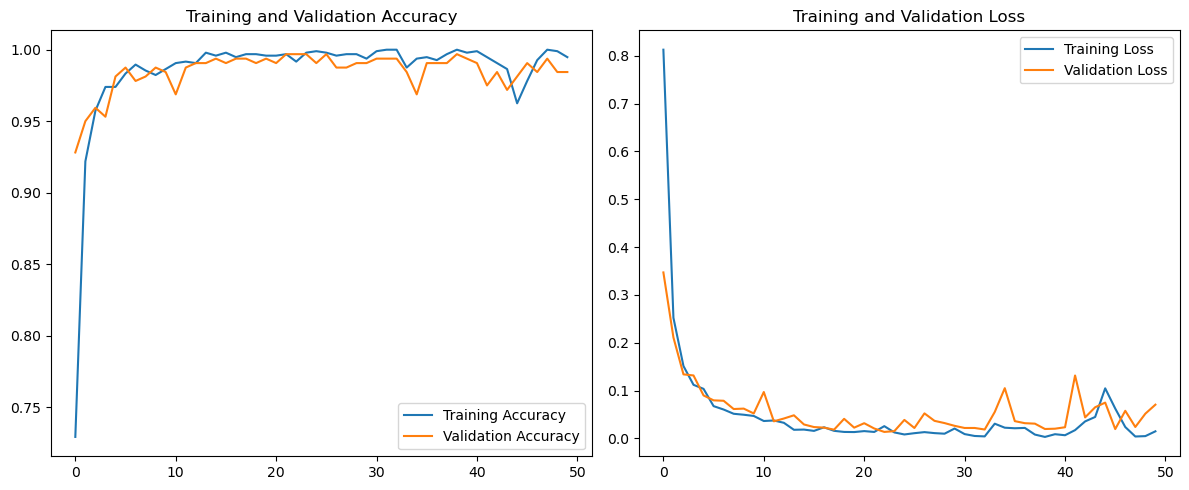

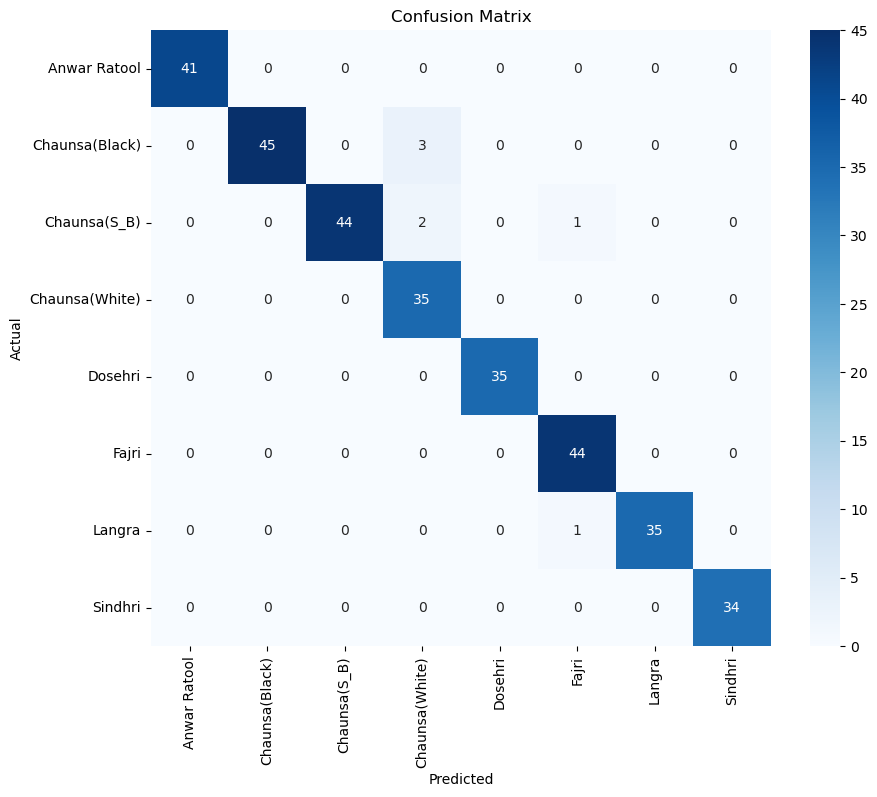

Model saved to F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_transfer_learning_model.h5
Training history saved to F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_training_history.xlsx
Metrics saved to F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_model_metrics.xlsx


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss
)
import seaborn as sns
import pandas as pd

# Initialize memory tracking
tracemalloc.start()

# Load and preprocess images
image_paths = []
labels = []

root_dir = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ML_Models\Classification_dataset"
for label in os.listdir(root_dir):
    label_dir = os.path.join(root_dir, label)
    if os.path.isdir(label_dir):
        for filename in os.listdir(label_dir):
            if filename.endswith(".jpg"):
                image_paths.append(os.path.join(label_dir, filename))
                labels.append(label)

# Load images into arrays
images = []
for image_path in image_paths:
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    images.append(img_array)

X = np.array(images)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split dataset into train, validation, and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Build transfer learning model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train model and measure time
start_time = time.time()
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    batch_size=32)
training_time = time.time() - start_time

# Save the trained model
model_path = r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_transfer_learning_model.h5'
save_model(model, model_path)

# Save training history
history_df = pd.DataFrame(history.history)
history_path = r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_training_history.xlsx'
history_df.to_excel(history_path, index=False)

# Evaluate on test set
start_time = time.time()
test_loss, test_acc = model.evaluate(X_test, y_test)
evaluation_time = time.time() - start_time

# Predictions and metrics
start_time = time.time()
y_pred = model.predict(X_test)
inference_time = (time.time() - start_time) / len(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
test_log_loss = log_loss(y_test, y_pred)

# Compute confusion matrix and class-wise accuracy
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)  # Per-class accuracy

# Convert class-wise accuracy to a DataFrame
class_accuracy_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Accuracy': class_wise_accuracy
})

# Memory usage
current, peak = tracemalloc.get_traced_memory()
memory_usage = peak / (1024 ** 2)  # Convert to MB
tracemalloc.stop()

# Save metrics to Excel
metrics_data = {
    'Training Accuracy': history.history['accuracy'][-1],
    'Validation Accuracy': history.history['val_accuracy'][-1],
    'Test Accuracy': test_acc,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Log Loss': test_log_loss,
    'Training Time (s)': training_time,
    'Inference Time (s/img)': inference_time,
    'Peak Memory Usage (MB)': memory_usage
}

metrics_df = pd.DataFrame([metrics_data])

# Save confusion matrix and class-wise accuracy to Excel
metrics_path = r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_model_metrics.xlsx'
with pd.ExcelWriter(metrics_path) as writer:
    metrics_df.to_excel(writer, sheet_name="Metrics", index=False)
    class_accuracy_df.to_excel(writer, sheet_name="Class Accuracy", index=False)
    pd.DataFrame(conf_matrix, index=label_encoder.classes_, columns=label_encoder.classes_).to_excel(writer, sheet_name="Confusion Matrix")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.savefig(r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_training_history.png', dpi=300)
plt.show()

# Confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\confusion_matrix.png', dpi=300)
plt.show()

print(f"Model saved to {model_path}")
print(f"Training history saved to {history_path}")
print(f"Metrics saved to {metrics_path}")


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

# Paths
dataset_dir = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ML_Models\Classification_dataset"
model_path = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_transfer_learning_model.h5"
output_dir = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\GradCAM_Results"

os.makedirs(output_dir, exist_ok=True)

# Load model
model = load_model(model_path)

# Get last conv layer name (double check if it's 'top_conv')
last_conv_layer_name = "top_conv"

# Grad-CAM function
def generate_gradcam(image_path, class_index, output_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array_expanded = np.expand_dims(img_array, axis=0)

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array_expanded)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1).numpy()

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    original_img = cv2.imread(image_path)
    original_img = cv2.resize(original_img, (224, 224))
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_img, 0.6, heatmap_colored, 0.4, 0)

    cv2.imwrite(output_path, superimposed_img)

# Iterate over class folders
for class_index, folder_name in enumerate(sorted(os.listdir(dataset_dir))):
    folder_path = os.path.join(dataset_dir, folder_name)
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]
        if image_files:
            first_image_path = os.path.join(folder_path, image_files[0])
            output_path = os.path.join(output_dir, f"GradCAM_{folder_name}.jpg")
            print(f"Processing {folder_name} -> {image_files[0]}")
            generate_gradcam(first_image_path, class_index, output_path)

print(f"\n✅ Grad-CAM visualizations saved to: {output_dir}")



c:\Users\Wolverine\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Processing Anwar Ratool -> Anwar_Ratol_1.jpg
Processing Chaunsa(Black) -> Chaunsa(Black)_1.jpg
Processing Chaunsa(S_B) -> Chaunsa(S_B)_1.jpg
Processing Chaunsa(White) -> Chaunsa(White)_1.jpg
Processing Dosehri -> Dosehri_1.jpg
Processing Fajri -> Fajri_1.jpg
Processing Langra -> Langra_1.jpg
Processing Sindhri -> Sindhri_1.jpg

✅ Grad-CAM visualizations saved to: F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\GradCAM_Results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 710ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


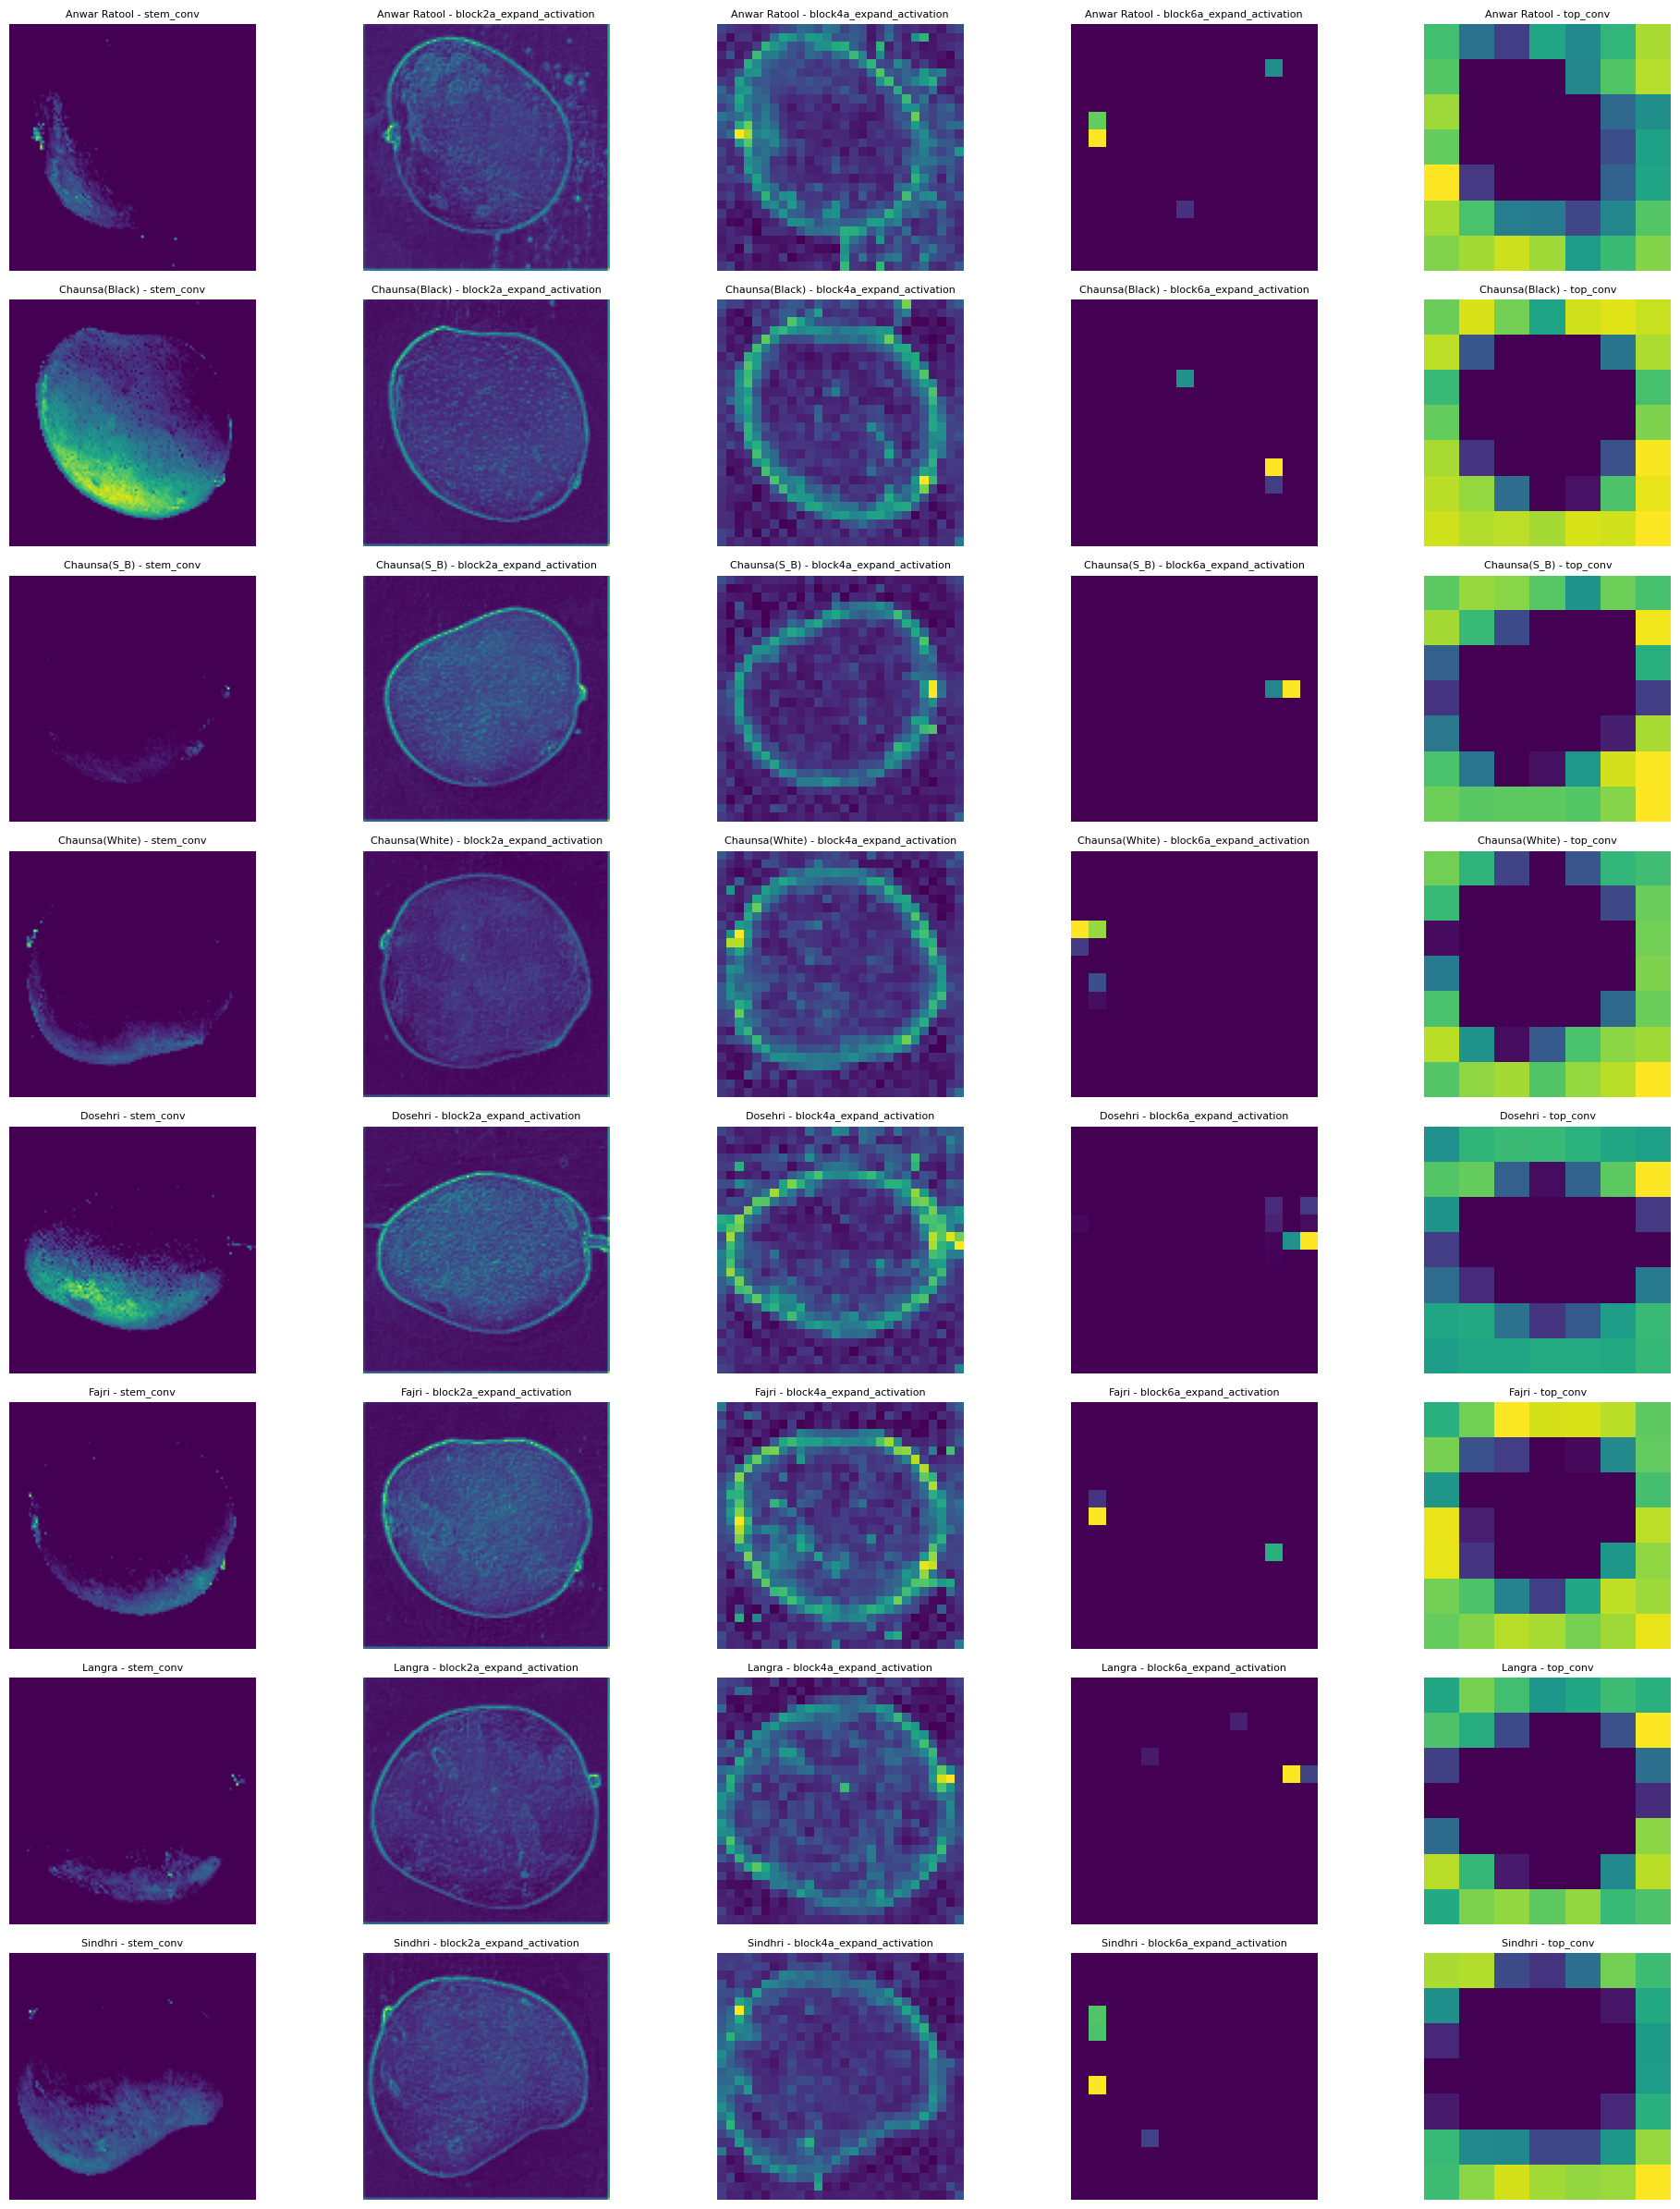

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

# Paths
dataset_path = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ML_Models\Classification_dataset"
model_path = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_transfer_learning_model.h5"

# Load model
model = load_model(model_path)

# Select important layer names
layer_names = ['stem_conv', 'block2a_expand_activation', 'block4a_expand_activation', 'block6a_expand_activation', 'top_conv']
intermediate_models = [Model(inputs=model.input, outputs=model.get_layer(name).output) for name in layer_names]

# Get first image from each folder
image_paths = []
labels = []
for label in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, label)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(class_path, file))
                labels.append(label)
                break

# Load and preprocess images
images = []
for path in image_paths:
    img = load_img(path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    images.append(img_array)

images = np.array(images)

# Compute activations
activation_maps = {layer: [] for layer in layer_names}
for name, inter_model in zip(layer_names, intermediate_models):
    activations = inter_model.predict(images)
    for i in range(len(images)):
        heatmap = np.mean(activations[i], axis=-1)
        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        activation_maps[name].append(heatmap)

# Plotting attention maps
fig, axes = plt.subplots(len(images), len(layer_names), figsize=(20, 3 * len(images)))
for i, label in enumerate(labels):
    for j, layer in enumerate(layer_names):
        ax = axes[i, j] if len(images) > 1 else axes[j]
        ax.imshow(activation_maps[layer][i], cmap='viridis')
        ax.set_title(f'{label} - {layer}', fontsize=8)
        ax.axis('off')

plt.tight_layout()
plt.show()






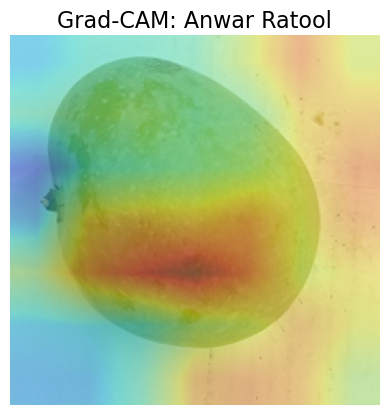

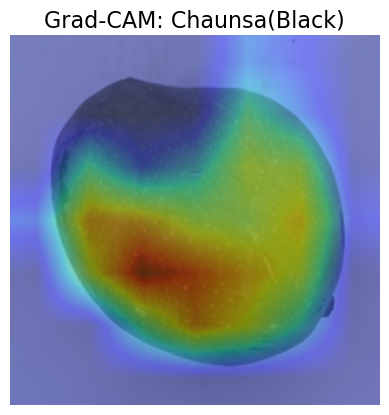

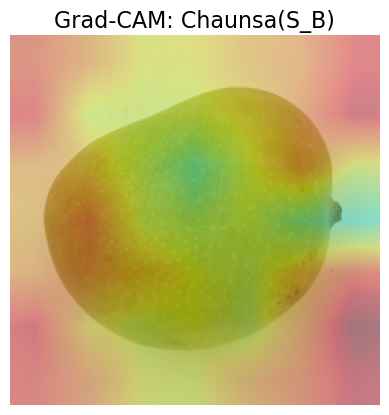

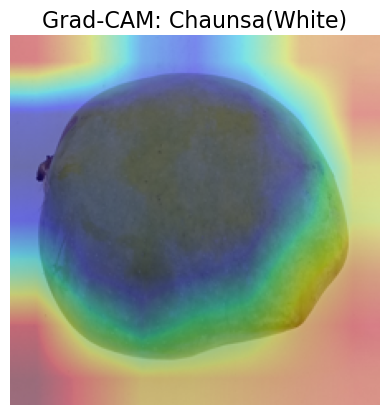

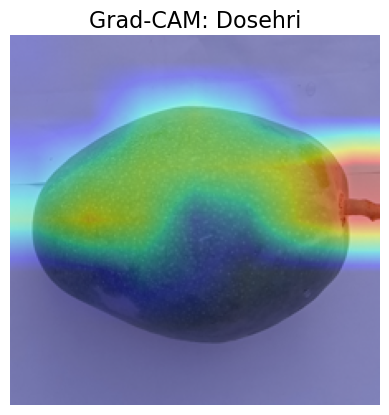

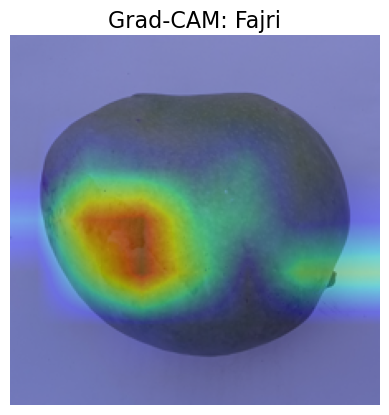

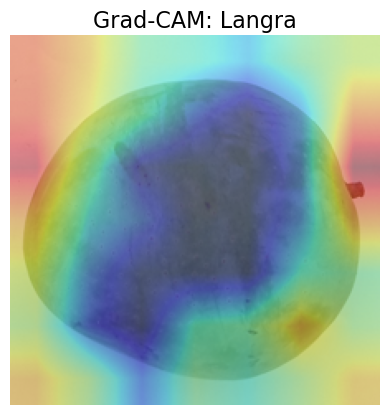

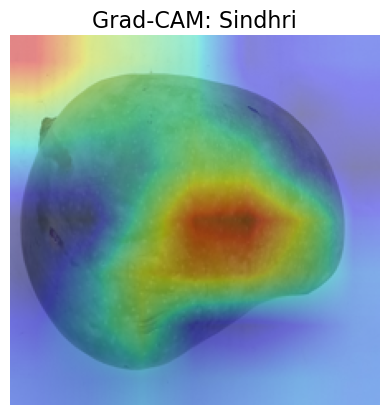

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

# Paths
dataset_path = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ML_Models\Classification_dataset"
model_path = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_transfer_learning_model.h5"

# Load model
model = load_model(model_path)

# Utility function to generate GradCAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay heatmap on image
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    img = load_img(img_path)
    img = img.resize((224, 224))
    img = np.array(img)

    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], [224, 224])
    heatmap = tf.squeeze(heatmap).numpy().astype(np.uint8)

    cmap = plt.get_cmap("jet")
    heatmap_color = cmap(heatmap)
    heatmap_color = tf.keras.utils.array_to_img(heatmap_color[..., :3])

    superimposed_img = heatmap_color.resize((224, 224))
    superimposed_img = np.array(superimposed_img)

    final_img = img * (1 - alpha) + superimposed_img * alpha
    final_img = np.clip(final_img / 255.0, 0, 1)
    return final_img

# Process first image from each class
last_conv_layer_name = "top_conv"  # EfficientNetB0 last conv layer
for label in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, label)
    if not os.path.isdir(class_folder):
        continue

    for file in os.listdir(class_folder):
        if file.lower().endswith(".jpg"):
            img_path = os.path.join(class_folder, file)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)

            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
            result = save_and_display_gradcam(img_path, heatmap)

            plt.imshow(result)
            plt.title(f'Grad-CAM: {label}',fontsize=16)
            plt.axis('off')
            plt.show()
            break


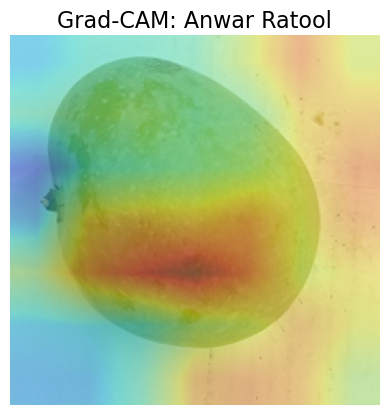

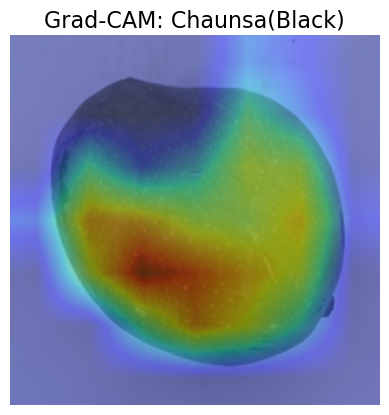

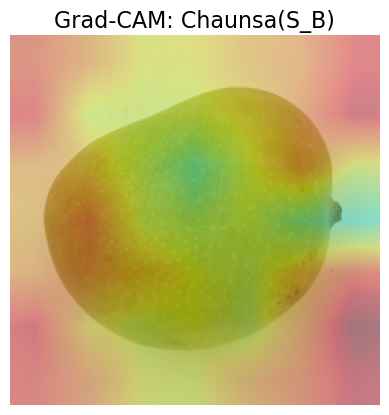

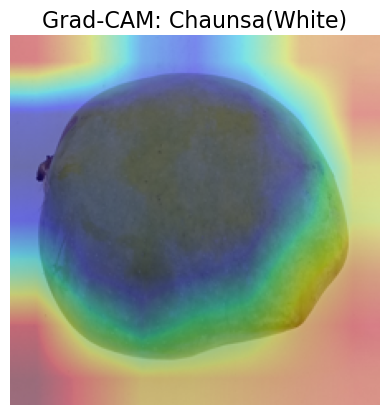

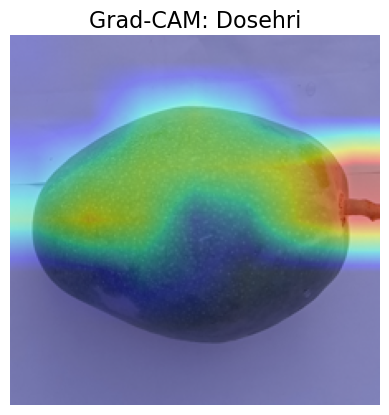

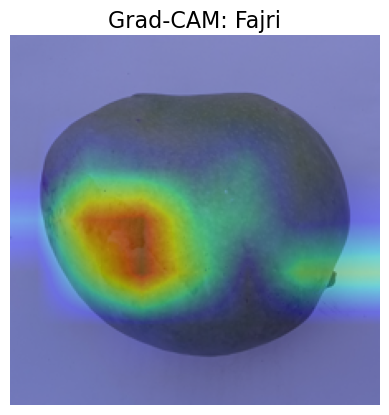

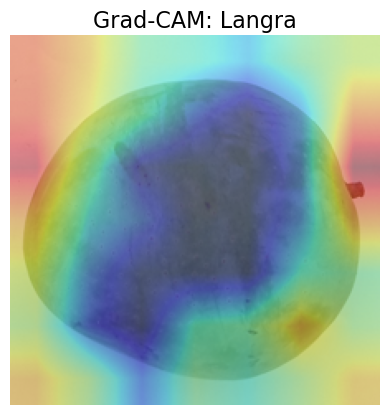

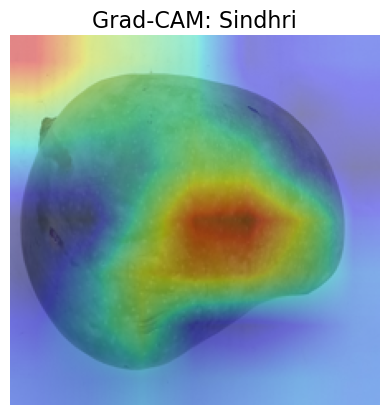

Grad-CAM attention maps saved to: F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\GradCAM_Attention


In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

# Paths
dataset_path = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ML_Models\Classification_dataset"
model_path = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_transfer_learning_model.h5"

# Load model
model = load_model(model_path)

# Utility function to generate GradCAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay heatmap on image
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    img = load_img(img_path)
    img = img.resize((224, 224))
    img = np.array(img)

    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], [224, 224])
    heatmap = tf.squeeze(heatmap).numpy().astype(np.uint8)

    cmap = plt.get_cmap("jet")
    heatmap_color = cmap(heatmap)
    heatmap_color = tf.keras.utils.array_to_img(heatmap_color[..., :3])

    superimposed_img = heatmap_color.resize((224, 224))
    superimposed_img = np.array(superimposed_img)

    final_img = img * (1 - alpha) + superimposed_img * alpha
    final_img = np.clip(final_img / 255.0, 0, 1)
    return final_img

# Create the folder to save the results
output_folder = r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\GradCAM_Attention'
os.makedirs(output_folder, exist_ok=True)

# Process first image from each class
last_conv_layer_name = "top_conv"  # EfficientNetB0 last conv layer
for label in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, label)
    if not os.path.isdir(class_folder):
        continue

    for file in os.listdir(class_folder):
        if file.lower().endswith(".jpg"):
            img_path = os.path.join(class_folder, file)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)

            # Generate heatmap
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
            
            # Save and display the result
            result = save_and_display_gradcam(img_path, heatmap)

            # Title font size set to 16
            plt.imshow(result)
            plt.title(f'Grad-CAM: {label}', fontsize=16)  # Set readable title size
            plt.axis('off')

            # Save the image at 300 DPI quality
            save_path = os.path.join(output_folder, f'GradCAM_{label}.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save with 300 DPI
            plt.show()
            break  # Only process the first image in each class

print(f"Grad-CAM attention maps saved to: {output_folder}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


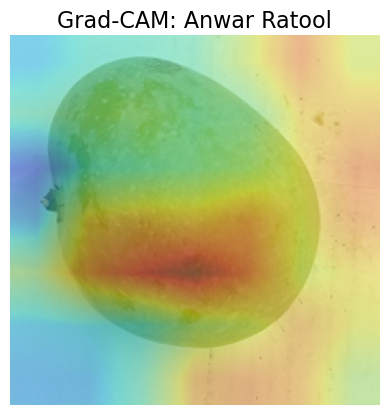

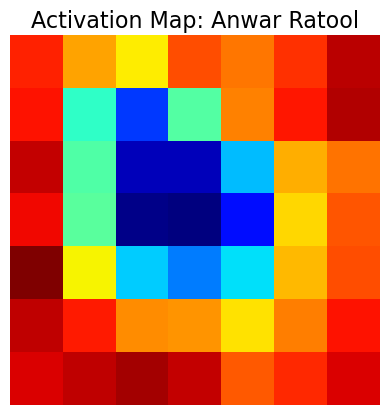

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


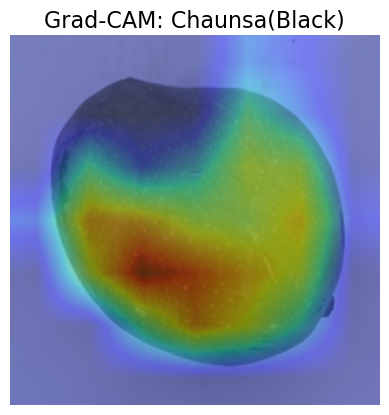

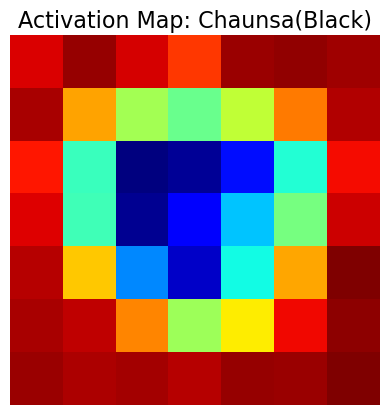

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


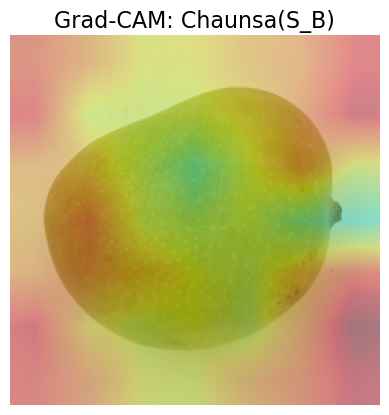

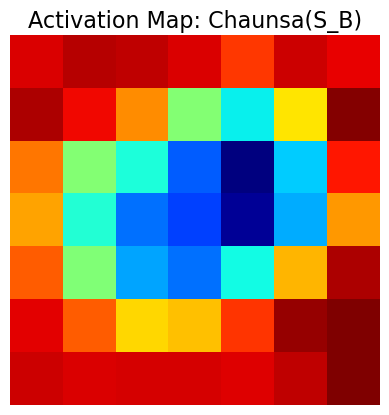

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


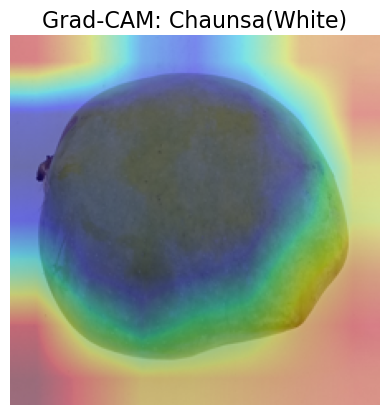

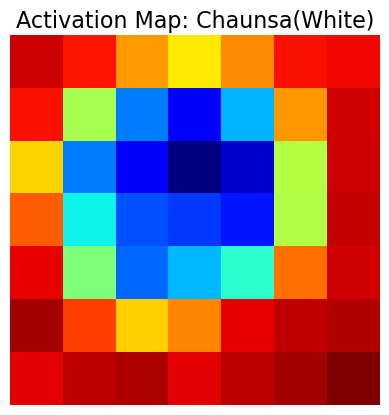

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


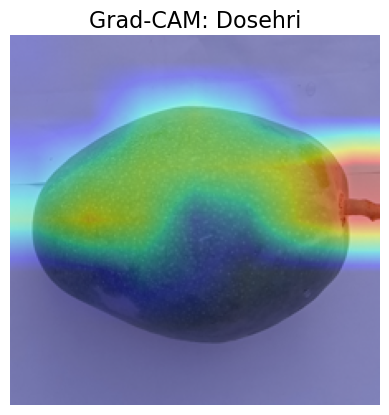

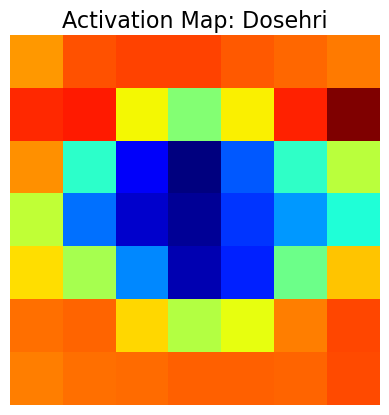

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


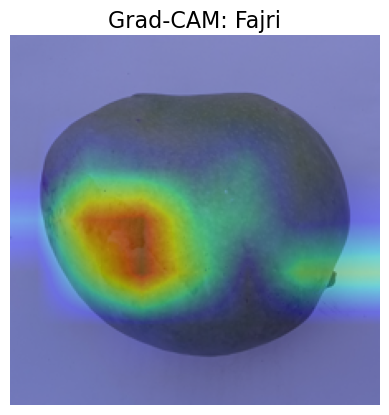

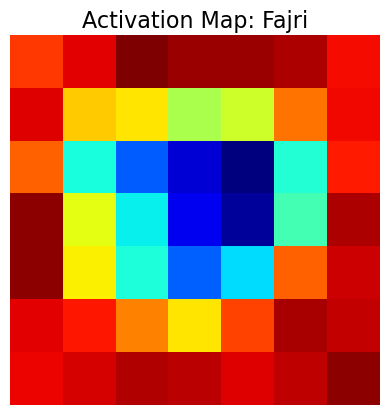

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


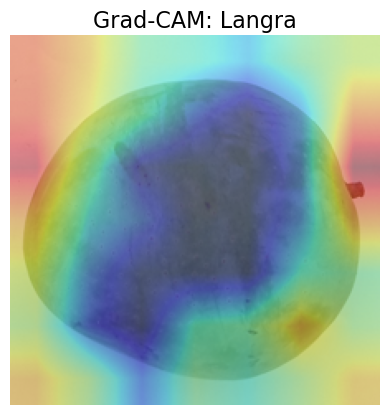

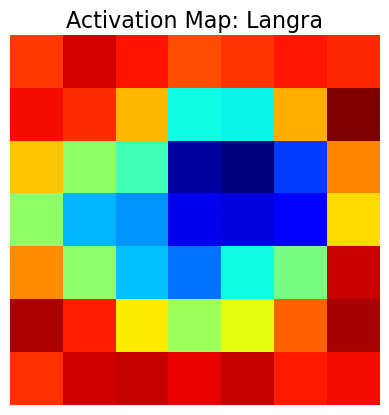

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


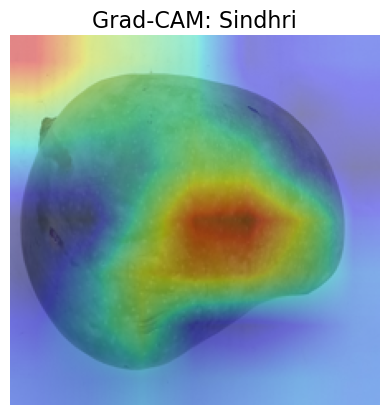

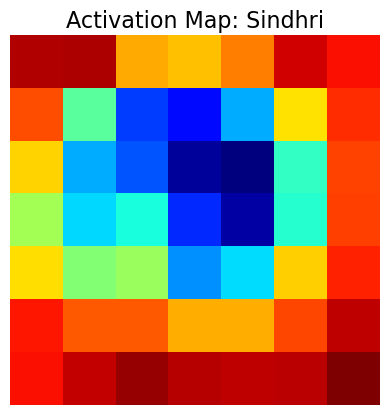

Grad-CAM and activation maps saved to: F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\GradCAM_Attention


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions

# Paths
dataset_path = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\ML_Models\Classification_dataset"
model_path = r"F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\EfficientNetB0_transfer_learning_model.h5"

# Load model
model = load_model(model_path)

# Utility function to generate GradCAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Utility function to get activation maps
def get_activation_map(img_array, model, layer_name):
    layer_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    activations = layer_model.predict(img_array)
    return activations[0]

# Overlay heatmap on image
def save_and_display_gradcam(img_path, heatmap, alpha=0.4):
    img = load_img(img_path)
    img = img.resize((224, 224))
    img = np.array(img)

    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], [224, 224])
    heatmap = tf.squeeze(heatmap).numpy().astype(np.uint8)

    cmap = plt.get_cmap("jet")
    heatmap_color = cmap(heatmap)
    heatmap_color = tf.keras.utils.array_to_img(heatmap_color[..., :3])

    superimposed_img = heatmap_color.resize((224, 224))
    superimposed_img = np.array(superimposed_img)

    final_img = img * (1 - alpha) + superimposed_img * alpha
    final_img = np.clip(final_img / 255.0, 0, 1)
    return final_img

# Create the folder to save the results
output_folder = r'F:\PhD_Zhejiang University\Mango\Final_Paper_Data_Transfer learning\GradCAM_Attention'
os.makedirs(output_folder, exist_ok=True)

# Process first image from each class
last_conv_layer_name = "top_conv"  # EfficientNetB0 last conv layer
for label in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, label)
    if not os.path.isdir(class_folder):
        continue

    for file in os.listdir(class_folder):
        if file.lower().endswith(".jpg"):
            img_path = os.path.join(class_folder, file)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            img_array = np.expand_dims(img_array, axis=0)

            # Generate Grad-CAM heatmap
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
            
            # Generate activation map for the last convolutional layer
            activations = get_activation_map(img_array, model, last_conv_layer_name)
            activation_map = np.mean(activations, axis=-1)  # Average over all channels

            # Save and display the result for Grad-CAM
            result = save_and_display_gradcam(img_path, heatmap)
            plt.imshow(result)
            plt.title(f'Grad-CAM: {label}', fontsize=16)
            plt.axis('off')

            # Save Grad-CAM at 300 DPI
            gradcam_save_path = os.path.join(output_folder, f'GradCAM_{label}.png')
            plt.savefig(gradcam_save_path, dpi=300, bbox_inches='tight')
            plt.show()

            # Display and save the activation map
            plt.imshow(activation_map, cmap='jet')
            plt.title(f'Activation Map: {label}', fontsize=16)
            plt.axis('off')

            # Save activation map at 300 DPI
            activation_map_save_path = os.path.join(output_folder, f'ActivationMap_{label}.png')
            plt.savefig(activation_map_save_path, dpi=300, bbox_inches='tight')
            plt.show()
            break  # Only process the first image in each class

print(f"Grad-CAM and activation maps saved to: {output_folder}")
